# GETTING THE URL FEATURES 

In [1]:
from requests import get
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import datetime

### The URL's collected from the mongoDB database are passed through ths Pooling and URLFeaturizer to obtain their information 

In [2]:
## This gets elite proxy from https://pypi.org/project/fake-useragent/ on every request
class Pooling(object):
    def __init__(self):
        self.proxies_url = ''

    '''returns a list of currently available elite proxies'''
    def proxy_pool(self, url = 'https://free-proxy-list.net/'):
        pq, proxies = get_page(url), []
        tr = pq('table#proxylisttable.table tbody tr')
        rows = [j.text() for j in [PyQuery(i)('td') for i in tr]]
        rows = [i for i in rows if 'elite' in i]

        for row in rows:

            row = row.split()
            data = {}
            data['ip'] = row[0]
            data['port'] = row[1]
            data['country'] = row[3]
            data['proxy'] = {
                'http' :'http://{}:{}'.format(data['ip'], data['port']),
                'https' :'https://{}:{}'.format(data['ip'], data['port'])}
            proxies.append(data)
            return choice(proxies)
        
        '''return a random list of user agents'''
        def ua_pool(self):
            ua = UserAgent()
            chromes = ua.data['browsers']['chrome'][5:40]
            shuffle(chromes)
            return choice(chromes)

In [3]:
class UrlFeaturizer(object):
    def __init__(self, url):
        self.url = url
        self.domain = url.split('//')[-1].split('/')[0]
        self.today = datetime.now()

        try:
            self.whois = whois.query(self.domain).__dict__
        except:
            self.whois = None

        try:
            self.response = get(self.url)
            self.pq = PyQuery(self.response.text)
        except:
            self.response = None
            self.pq = None

    ## URL string Features
    def entropy(self):
        string = self.url.strip()
        prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
        entropy = sum([(p * math.log(p) / math.log(2.0)) for p in prob])
        return entropy

    def numDigits(self):
        digits = [i for i in self.url if i.isdigit()]
        return len(digits)

    def urlLength(self):
        return len(self.url)

    def numParameters(self):
        params = self.url.split('&')
        return len(params) - 1

    def numFragments(self):
        fragments = self.url.split('#')
        return len(fragments) - 1

    def numSubDomains(self):
        subdomains = self.url.split('http')[-1].split('//')[-1].split('/')
        return len(subdomains)-1

    def domainExtension(self):
        ext = self.url.split('.')[-1].split('/')[0]
        return ext

    ## URL domain features
    def hasHttp(self):
        return 'http:' in self.url

    def hasHttps(self):
        return 'https:' in self.url

    def urlIsLive(self):
        return self.response == 200

    def daysSinceRegistration(self):
        if self.whois and self.whois['creation_date']:
            diff = self.today - self.whois['creation_date']
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0

    def daysSinceExpiration(self):
        if self.whois and self.whois['expiration_date']:
            diff = self.whois['expiration_date'] - self.today
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0

    ## URL Page Features
    def bodyLength(self):
        if self.pq is not None:
            return len(self.pq('html').text()) if self.urlIsLive else 0
        else:
            return 0

    def numTitles(self):
        if self.pq is not None:
            titles = ['h{}'.format(i) for i in range(7)]
            titles = [self.pq(i).items() for i in titles]
            return len([item for s in titles for item in s])
        else:
            return 0

    def numImages(self):
        if self.pq is not None:
            return len([i for i in self.pq('img').items()])
        else:
            return 0

    def numLinks(self):
        if self.pq is not None:
            return len([i for i in self.pq('a').items()])
        else:
            return 0

    def scriptLength(self):
        if self.pq is not None:
            return len(self.pq('script').text())
        else:
            return 0

    def specialCharacters(self):
        if self.pq is not None:
            bodyText = self.pq('html').text()
            schars = [i for i in bodyText if not i.isdigit() and not i.isalpha()]
            return len(schars)
        else:
            return 0

    def scriptToSpecialCharsRatio(self):
        if self.pq is not None:
            sscr = self.scriptLength()/self.specialCharacters
        else:
            sscr = 0
        return sscr

    def scriptTobodyRatio(self):
        if self.pq is not None:
            sbr = self.scriptLength()/self.bodyLength
        else:
            sbr = 0
        return sbr

    def bodyToSpecialCharRatio(self):
        if self.pq is not None:
            bscr = self.specialCharacters()/self.bodyLength
        else:
            bscr = 0
        return bscr

    def run(self):
        data = {}
        data['entropy'] = self.entropy()
        data['numDigits'] = self.numDigits()
        data['urlLength'] = self.urlLength()
        data['numParams'] = self.numParameters()
        data['hasHttp'] = self.hasHttp()
        data['hasHttps'] = self.hasHttps()
        data['urlIsLive'] = self.urlIsLive()
        data['bodyLength'] = self.bodyLength()
        data['numTitles'] = self.numTitles()
        data['numImages'] = self.numImages()
        data['numLinks'] = self.numLinks()
        data['scriptLength'] = self.scriptLength()
        data['specialChars'] = self.specialCharacters()
        data['ext'] = self.domainExtension()
        data['dsr'] = self.daysSinceRegistration()
        data['dse'] = self.daysSinceExpiration()
        data['sscr'] = self.scriptToSpecialCharsRatio()
        data['sbr'] = self.scriptTobodyRatio()
        data['bscr'] = self.bodyToSpecialCharRatio()
        return data

In [4]:
urls = UrlFeaturizer("tweets.csv")
urls.run()

{'entropy': -2.721928094887362,
 'numDigits': 0,
 'urlLength': 10,
 'numParams': 0,
 'hasHttp': False,
 'hasHttps': False,
 'urlIsLive': False,
 'bodyLength': 0,
 'numTitles': 0,
 'numImages': 0,
 'numLinks': 0,
 'scriptLength': 0,
 'specialChars': 0,
 'ext': 'csv',
 'dsr': 0,
 'dse': 0,
 'sscr': 0,
 'sbr': 0,
 'bscr': 0}

# IMPLEMENTING THE ML MODEL FOR PREDICTING THE MALICIOUS TWEETS 

In [6]:
data = pd.read_csv('scanned_data.csv')
data.head()

,Unnamed: 0,Unnamed: 0.1,numServices,robots,totalscans,detections,vt_class,entropy,numDigits,urlLength,...,numImages,numLinks,scriptLength,specialChars,ext,dsr,dse,sscr,sbr,bscr
0,0,0,0,False,76,6,Benign,-4.316048,2,90,...,0,0,0,0,com,5789,54,0.000000,0.000000,0.000000
1,1,1,2,False,76,6,Benign,-4.389681,6,92,...,7,124,17321,6426,com,9052,443,2.695456,0.794796,0.294865
2,2,2,8,False,76,5,Benign,-4.550597,29,115,...,31,181,8248,3163,html,6692,1708,2.607651,0.616811,0.236539
3,3,3,0,False,0,0,Benign,-4.101809,0,47,...,0,0,0,0,html,84,282,0.000000,0.000000,0.000000
4,4,4,1,False,71,7,Benign,-4.633752,14,96,...,0,0,0,0,php?name1st=%E3%82%8A&all=1&all2=1&all3=1&all4...,5091,1848,0.000000,0.000000,0.000000


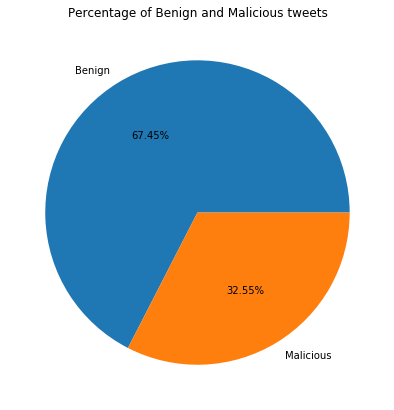

In [7]:
# display categorical output
vt_data = pd.DataFrame(data, columns=["vt_class"])
# converting to binary data
df_one = pd.get_dummies(vt_data["vt_class"])
df_two = pd.concat((df_one, vt_data), axis=1)
df_two = df_two.drop(["vt_class"], axis=1)
df_two = df_two.drop(["Benign"], axis=1)
result = df_two.rename(columns={"Malicious": "vt_class"})
fig = plt.figure(figsize =(10, 7))
plt.title("Percentage of Benign and Malicious tweets")
plt.pie(result["vt_class"].value_counts(1)*100, labels = np.array(['Benign','Malicious']), autopct='%1.2f%%')
plt.show()

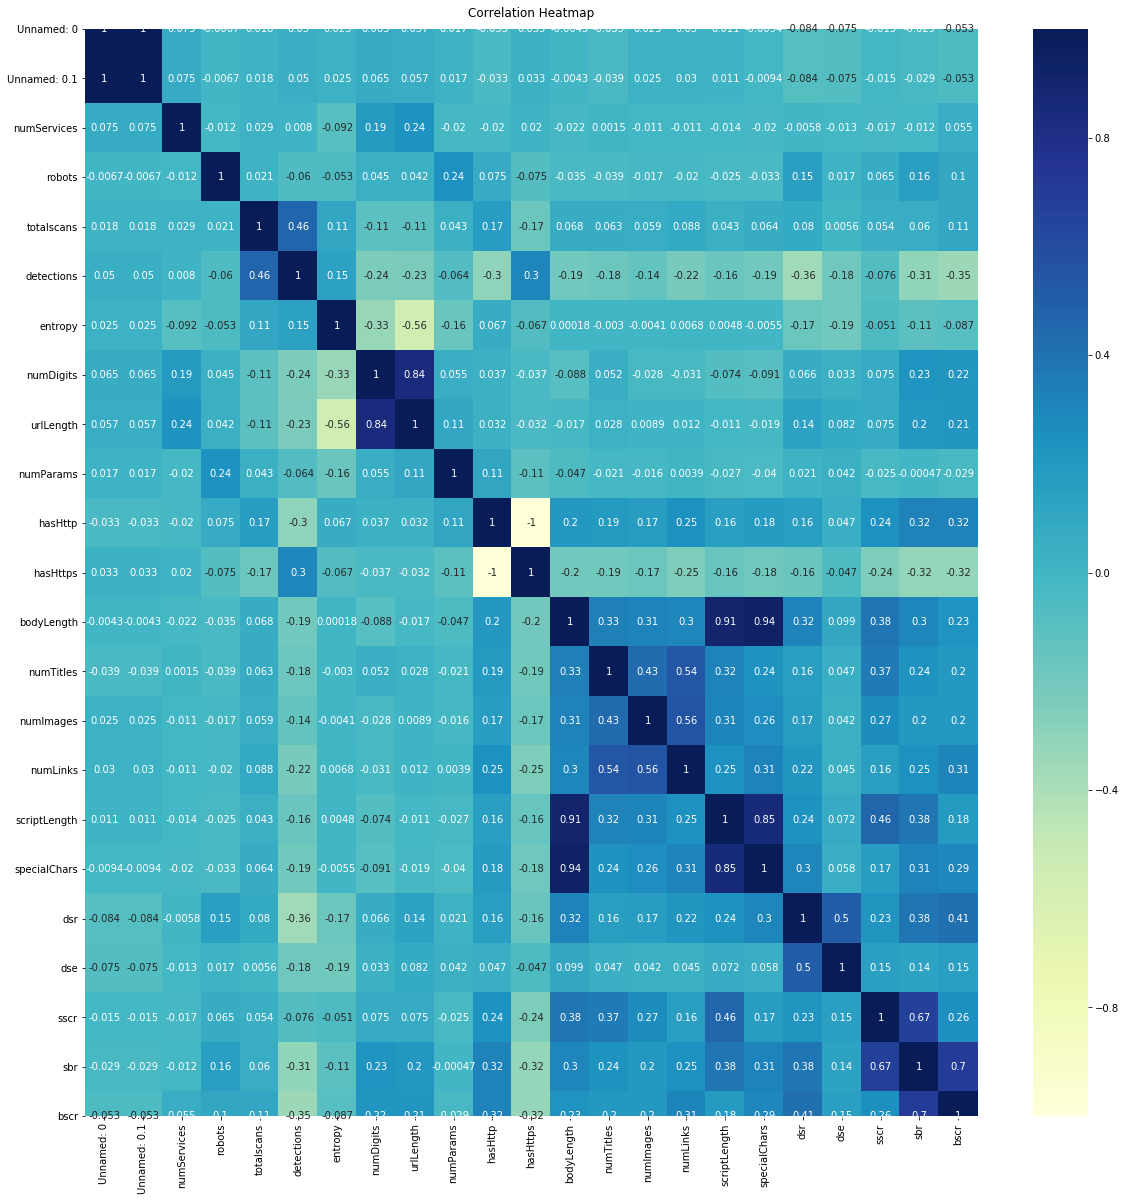

In [8]:
# columns shown here are selected by corr() since they are ideal for the plot  
# plotting correlation heatmap
plt.figure(figsize=(20, 20))
dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)
dataplot.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
  
# displaying heatmap
plt.show()

In [11]:
def dropMultiCorrelated(cormat, threshold):
    ##Define threshold to remove pairs of features with correlation coefficient greater than 0.5 or -0.5
    threshold = 0.5

    # Select upper triangle of correlation matrix
    upper = cormat.abs().where(np.triu(np.ones(cormat.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    for d in to_drop:
        print("Dropping {}....".format(d))
    return to_drop

In [13]:
objects = [i for i in data.columns if 'object' in str(data.dtypes[i])]
booleans = [i for i in data.columns if 'bool' in str(data.dtypes[i])]
ints = [i for i in data.columns if 'int' in str(data.dtypes[i]) or 'float' in str(data.dtypes[i])]
corr = data[ints+booleans].corr()
data2 = data[corr.columns].drop(dropMultiCorrelated(corr, 0.7), axis=1)

Dropping Unnamed: 0.1....
Dropping urlLength....
Dropping numLinks....
Dropping scriptLength....
Dropping specialChars....
Dropping sbr....
Dropping bscr....
Dropping hasHttps....


In [14]:
data2 = data2.drop('Unnamed: 0', axis=1)
data2

,numServices,totalscans,detections,entropy,numDigits,numParams,bodyLength,numTitles,numImages,dsr,dse,sscr,robots,hasHttp
0,0,76,6,-4.316048,2,0,0,0,0,5789,54,0.000000,False,True
1,2,76,6,-4.389681,6,0,21793,6,7,9052,443,2.695456,False,True
2,8,76,5,-4.550597,29,0,13372,91,31,6692,1708,2.607651,False,True
3,0,0,0,-4.101809,0,0,0,0,0,84,282,0.000000,False,True
4,1,71,7,-4.633752,14,5,0,0,0,5091,1848,0.000000,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,19,76,7,-3.498950,131,0,2643,2,3,2595,326,2.852381,False,True
546,0,77,15,-4.312147,1,0,0,0,0,915,180,0.000000,False,True
547,17,76,13,-4.198604,0,1,186,1,0,0,0,0.000000,False,True
548,2,76,5,-4.495622,7,0,13913,6,7,9052,443,2.708508,False,True


In [15]:
selected_columns = data2.columns
d = data2[selected_columns]
x = d[selected_columns]
y = data['vt_class']

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 32)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

C:\Users\sriva\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [18]:
acc = accuracy_score(y_test, y_pred)*100
print("The Accuracy of our LR Model is " + str(round(acc,2)) + " %")

The Accuracy of our LR Model is 95.45 %
